# The Askeladden Algorithm <a class="tocSkip">

## W207 | Applied Machine Learning | Spring 2019<a class="tocSkip">

### Team Troll Trappers: Laura Pintos, Ramiro Cadavid, and Anna Jacobson<a class="tocSkip">

## Introduction

In February 2019, as part of special counsel Robert Mueller’s investigation of the Russian government's efforts to interfere in the 2016 presidential election, the United States Department of Justice charged 13 Russian nationals with illegally meddling in American political processes. The defendants worked for a well-funded “troll factory” called the Internet Research Agency (IRA), which reportedly had 400 employees, or “trolls”,  working 12-hour shifts from a nondescript business center in St. Petersburg. The IRA ran a sophisticated, coordinated campaign to spread disinformation and sow discord into American politics via social media, often Twitter. 

Twitter has identified and suspended thousands of these malicious accounts, deleting millions of the trolls’ tweets from public view on the platform. While other news outlets have published samples, it has been difficult to understand the full scale and scope of the IRA’s efforts, as well as the details of its strategy and tactics. According to Alina Polyakova, a foreign policy fellow at the Brookings Institution, “Wiping the content doesn’t wipe out the damage caused, and it prevents us from learning about how to be better prepared for such attacks in the future.” To address this problem, and “in line with our principles of transparency and to improve public understanding of alleged foreign influence campaigns,” Twitter has now made publicly available archives of Tweets and media that it believes resulted from potentially state-backed information operations.

According to a December 2018 United States Senate Select Committee on Intelligence briefing, there were approximately 109 Twitter accounts masquerading as news organizations, including U.S. local news organizations. The 44 U.S.-related accounts had amassed 660,335 followers between them, with an average of 15,000 followers. Many of these accounts behaved similarly, posting links to articles and local content dozens of times per day. 

The purpose of this project is to develop a machine learning algorithm to predict "fake news" troll tweets. Our algorithm is named after Askeladden, a boy in Norwegian folklore who outwits trolls.

**Setup**

In [1]:
# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import string
import csv
import datetime
import pandas_ml as pdml
import seaborn as sns
from collections import defaultdict

#SK-learn libraries for preprocessing
from sklearn.datasets import fetch_mldata
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from textblob import TextBlob

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.neighbors import NearestCentroid
from sklearn.feature_selection import SelectFromModel

# SK-learn libraries for model selection and evaluation.
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Complementary libraries
from pandas_ml import ConfusionMatrix
from pprint import pprint
from time import time
from wordcloud import WordCloud
from pylab import *
import nltk

# Word2Vec libraries
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence
import multiprocessing
from sklearn import utils

# Set seed for random states
seed = 2019

## The Data

### Data Sources

#### Troll Tweets

In October 2018, Twitter published a collection of datasets that includes all public, undeleted tweets and media (e.g., images and videos) for 3,613 accounts that Twitter believes are connected to the Russian state-backed information operation Internet Research Agency (IRA). Tweets deleted by these users prior to their suspension (which are not included in these datasets) comprise less than 1% of their overall activity. The data consists of the full archive of information disclosed about the IRA. We decided to focus on the tweets dataset, which includes 8,768,633 unique tweets from May 2009 to June 2018. After filtering for English language tweets only, there are just under 3 million unique tweets in the dataset (2,997,181). These tweets come from 3,077 unique user accounts.

We defined our period of interest as 2016-2018. In order to segregate the "fake news" trolls, we filtered for user screen names containing the words 'Daily', 'New', 'Today', and 'Online'. This yielded 296,949 unique tweets from 33 unique user accounts with screen names such as TodayNYCity, ChicagoDailyNew, and KansasDailyNews. We randomly sampled this set of data to get the same number of tweets as our real news tweet dataset (see below).

#### Real News Tweets

Harvard Dataverse published a dataset containing the tweet IDs of 39,695,156 tweets collected from the Twitter accounts of approximately 4,500 news outlets (i.e., accounts of media organizations intended to disseminate news). The media organizations include everything from local U.S. newspapers to foreign television stations. They were collected between August 4, 2016 and July 20, 2018 from the Twitter API. 

Twitter's Developer Policy (which you agree to when you get keys for the Twitter API) places limits on the sharing of datasets. If you are sharing datasets of tweets, you can only publicly share the ids of the tweets, not the tweets themselves. Thus, this dataset, only contained the tweets ids. Based on the tweet ID, we retrieved the complete tweet from the Twitter API. We selected a variety of news outlets, including Politico, Fox News, CNN, The Economist, and MSNBC. In total, we have included 153,188 unique tweets from 49 unique user accounts.

#### Combined News Tweets

For this analysis, we combined the troll tweets and the real news tweets, for a combined dataset of 306,376 tweets equally balanced between the two classes. We included the text of each tweet and its category ('real' or 'troll'). No other identifying information is included.

### Data Preparation

Load data and check balance:

In [2]:
df = pd.read_csv("Data/news_tweets_big.csv", index_col=0)
df.category.value_counts()

real     153188
troll    153188
Name: category, dtype: int64

Preview troll and real news tweets:

In [4]:
print("Troll Tweets")
df[df.category == 'troll'].head()

Troll Tweets


,tweet_text,category
0,Brewers-Cubs first pitch scheduled for 2:15 p....,troll
1,Even more medicine coming to Liberty Township ...,troll
2,Chicago fugitive apprehended in Lithonia https...,troll
3,11 killed in East TN wildfires; TBI investigat...,troll
4,GOP campaigns flock to Fargo to vie for delega...,troll


In [5]:
print("Real News Tweets")
df[df.category == 'real'].head()

Real News Tweets


,tweet_text,category
153188,Russia shrugs off reports Trump shared classif...,real
153189,Texas man reportedly imprisoned in United Arab...,real
153190,Giannis Antetokounmpo jumped over a 6-foot-6 d...,real
153191,Dramatic mood shift at Clinton HQ; Many aides ...,real
153192,RT @JaniceDean: A warm up for the eastern half...,real


Factorize categories:

In [6]:
# Factorize the categories.
d = {'real':0, 'troll':1}
df['category'] = df['category'].map(d)
print(df.category.value_counts())

# Check that troll = 1 (and therefore, real = 0).
df[df.category == 1].head()

1    153188
0    153188
Name: category, dtype: int64


,tweet_text,category
0,Brewers-Cubs first pitch scheduled for 2:15 p....,1
1,Even more medicine coming to Liberty Township ...,1
2,Chicago fugitive apprehended in Lithonia https...,1
3,11 killed in East TN wildfires; TBI investigat...,1
4,GOP campaigns flock to Fargo to vie for delega...,1


Set category as target:

In [7]:
my_df = pd.DataFrame(df,columns=['tweet_text'])
my_df['target'] = df.category
my_df.head()

,tweet_text,target
0,Brewers-Cubs first pitch scheduled for 2:15 p....,1
1,Even more medicine coming to Liberty Township ...,1
2,Chicago fugitive apprehended in Lithonia https...,1
3,11 killed in East TN wildfires; TBI investigat...,1
4,GOP campaigns flock to Fargo to vie for delega...,1


### Initial Data Exploration

Preview meta-data:

In [8]:
my_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306376 entries, 0 to 306375
Data columns (total 2 columns):
tweet_text    306376 non-null object
target        306376 non-null int64
dtypes: int64(1), object(1)
memory usage: 7.0+ MB


Generate word cloud for each category:

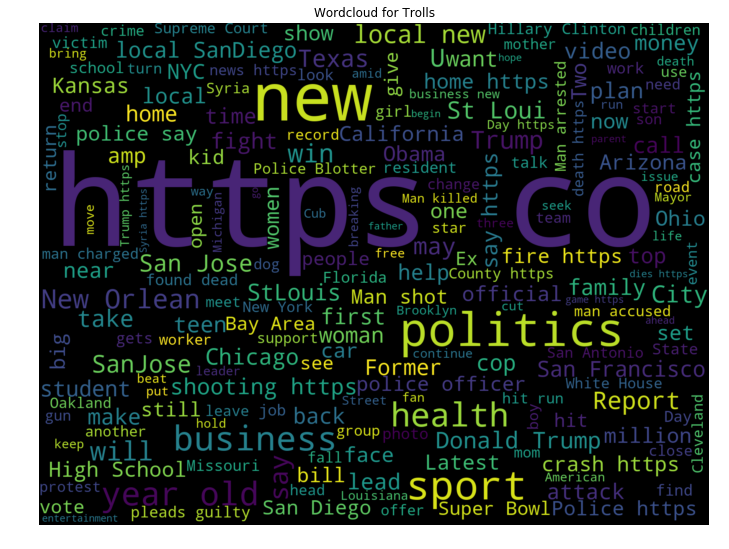

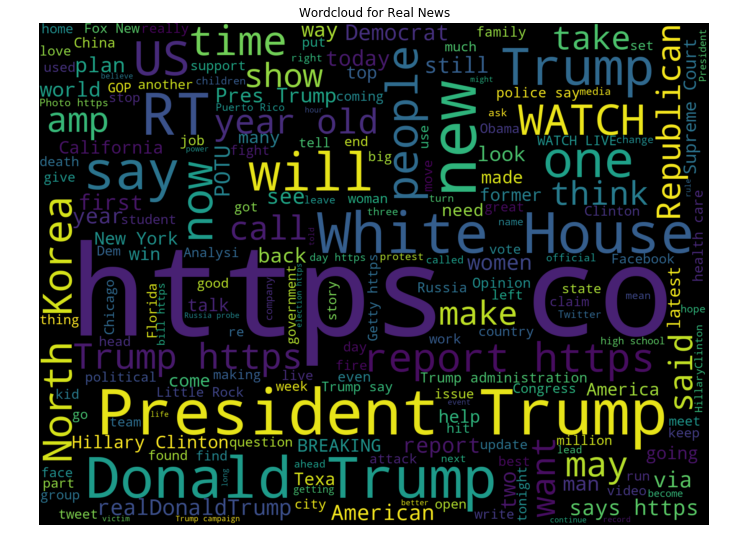

In [9]:
def wordcloud(target, category):
    '''
    Args:
        target (int): selected target for which to generate wordcloud
    ''' 
    # Strings to list of words
    tweets = my_df[my_df.target == target]
    string = []
    for t in tweets.tweet_text:
        string.append(t)
    string = pd.Series(string).str.cat(sep=' ')
    
    # Plot word cloud
    wordcloud = WordCloud(width=1600, height=1200,
                          max_font_size=300).generate(string)
    plt.figure(figsize=(12,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title('Wordcloud for %s'%category, fontsize = 12)
    plt.axis("off")
    plt.show()

# Generate wordcloud for troll and real tweets.
wordcloud(1, 'Trolls')
wordcloud(0, 'Real News')

Interestingly, since others' research has told us that the IRA intended to influence the 2016 presidential election, visual examination of the wordcloud for real news tweets shows references to Trump larger and more often.

Hashtags analysis:

/Applications/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


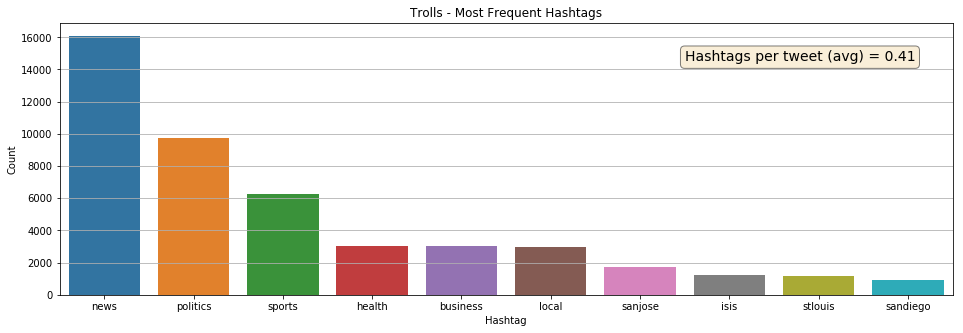

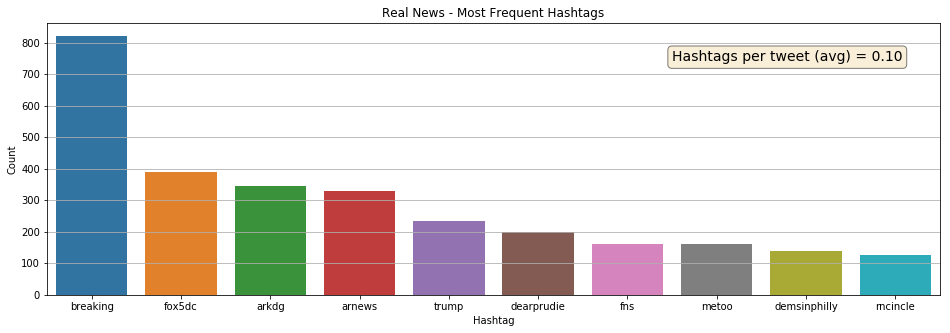

In [10]:
"""
Extract hashtags from tweet text
"""

# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

# extracting hashtags from trolls tweets
tweets = my_df.tweet_text
labels = my_df.target
HT_trolls = hashtag_extract(tweets[labels == 1])
ht_trolls = []
for lst in HT_trolls:
    for element in lst:
        ht_trolls.append(element.lower())

# extracting hashtags from real-news tweets
HT_real_news = hashtag_extract(tweets[labels == 0])
ht_real_news = []
for lst in HT_real_news:
    for element in lst:
        ht_real_news.append(element.lower())
        
"""
Plot hashtags per category
"""

def plot_ht(data, title, text):
    a = nltk.FreqDist(data)
    d = pd.DataFrame({'Hashtag': list(a.keys()),
                      'Count': list(a.values())})
    # selecting top 10 most frequent hashtags     
    d = d.nlargest(columns="Count", n = 10) 
    plt.figure(figsize=(16,5))
    ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
    ax.set(ylabel = 'Count')
    ax.set(title = title)
    ax.grid(axis='y')
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.7, 0.9, text, transform=ax.transAxes, fontsize=14,
    verticalalignment='top', bbox=props)
    plt.show()

plot_ht(ht_trolls, 'Trolls - Most Frequent Hashtags', "Hashtags per tweet (avg) = {:.2f}"
        .format(len(ht_trolls) / labels[labels == 1].shape[0]))
plot_ht(ht_real_news, 'Real News - Most Frequent Hashtags', "Hashtags per tweet (avg) = {:.2f}"
        .format(len(ht_real_news) / labels[labels == 0].shape[0]))

From the analysis of the most frequent hashtags included in the tweet text, it can be seen that both the frequency and the text used by trolls and real news contrasts deeply. In the first place, trolls tend to include many more hashtags in their text (0.41 hashtags per tweet, on average) than their real news counterpart (0.10). 

The text used in the hashtag also difers noticeably. While the troll accounts use the hashtag #news to present themselves as a news outlet, the real news have no need of using this hashtag and focus more on identifying their different products and branches (e.g. #fox5dc for Fox News, or #dearPrudie for Slate). Other than these, real news outlets use neutral hashtags to reference events or important characters, such as #demsInPhilly or #Trump, while trolls seem to use generic news themes, such as #politics, #sports or #business.

### Initial Feature Extraction Exploration

In order to better understand our data, we perform a light-touch feature extraction.

In [11]:
# Instantiate the vectorizer and fit the tweet text data.
cvec = CountVectorizer()
cvec.fit(my_df.tweet_text)

# # Number of features
print("Number of features = {0:,}".format(len(cvec.get_feature_names())))

""" 
Most frequently used features
"""
# Vectorize tweet text per category
real_doc_matrix = cvec.transform(my_df[my_df.target == 0].tweet_text)
troll_doc_matrix = cvec.transform(my_df[my_df.target == 1].tweet_text)

# Build term-frequency matrix
real_tf = np.sum(real_doc_matrix,axis=0)
troll_tf = np.sum(troll_doc_matrix,axis=0)
real = np.squeeze(np.asarray(real_tf))
troll = np.squeeze(np.asarray(troll_tf))
term_freq_df = pd.DataFrame([real,troll], columns=cvec.get_feature_names()).transpose()

# Build term-frequency per word, for each category
term_freq_df.columns = ['real', 'troll']
term_freq_df['total'] = term_freq_df['real'] + term_freq_df['troll']
print("\nTerm frequency per label:")
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

Number of features = 470,051

Term frequency per label:


,real,troll,total
https,195129,200634,395763
co,193992,201048,395040
to,57108,36722,93830
the,75335,15924,91259
in,41252,46682,87934
of,40905,23588,64493
for,24091,21394,45485
on,24203,15026,39229
trump,30352,8168,38520
and,25274,8751,34025


Plot the top 50 features for each category:

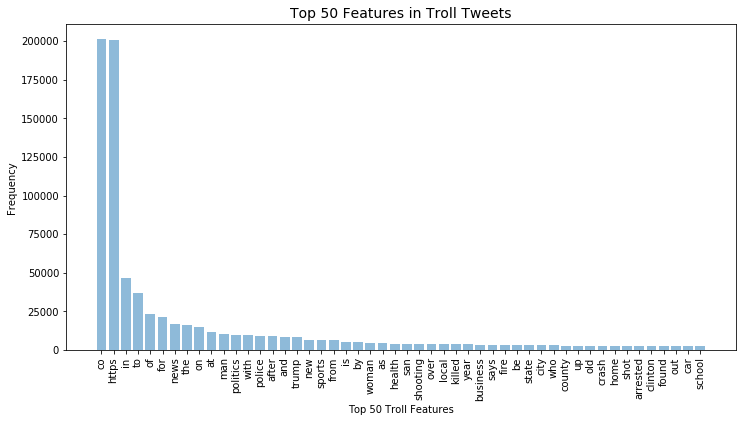

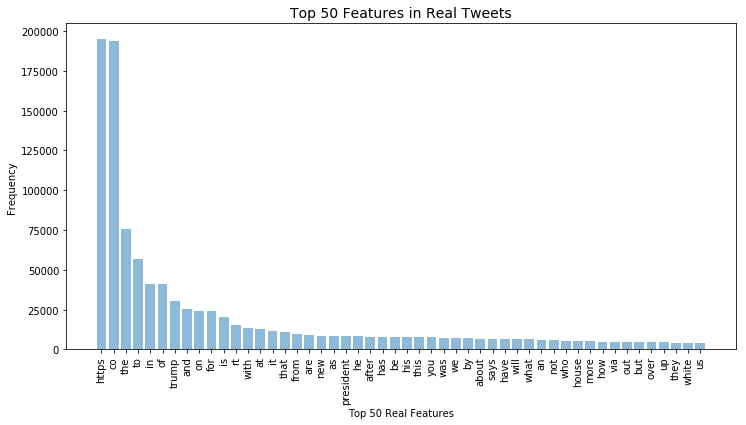

In [12]:
# Define function that plots top 50 features
def top_features(category):    
    '''
    args:
        category (str): specified category name.
    returns:
        (none): plots top 50 features.
    '''
    y_pos = np.arange(50)
    plt.figure(figsize=(12,6))
    plt.bar(y_pos, term_freq_df.sort_values(by=category, ascending=False)[category][:50], 
            align='center', alpha=0.5)
    plt.xticks(y_pos, term_freq_df.sort_values(by=category, ascending=False)[category][:50].index,rotation='vertical')
    plt.ylabel('Frequency')
    plt.xlabel('Top 50 %s Features'%category.title())
    plt.title('Top 50 Features in %s Tweets'%category.title(), fontsize=14)

# Run top_features for each category
top_features('troll')
top_features('real')

Plot the frequency of features per category:

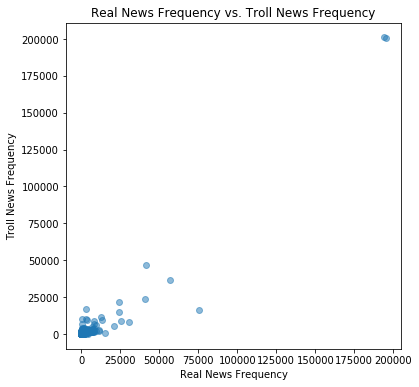

In [13]:
plt.figure(figsize=(6,6));
ax = sns.regplot(x="real", y="troll",fit_reg=False, 
                 scatter_kws={'alpha':0.5},data=term_freq_df)
plt.ylabel('Troll News Frequency')
plt.xlabel('Real News Frequency')
plt.title('Real News Frequency vs. Troll News Frequency')

### Data Split

In [14]:
# Split data into training, development, and test datasets.
x = my_df.tweet_text
y = my_df.target
x_train, x_dev_and_test, y_train, y_dev_and_test = train_test_split(x, y, test_size=0.2, random_state=seed)
x_dev, x_test, y_dev, y_test = train_test_split(x_dev_and_test, y_dev_and_test, test_size=0.5, random_state=seed)
targets = ['real','troll']

# Print results
print(f"""
Training data shape: ({x_train.shape[0]:,}, )
Development data shape: ({x_dev.shape[0]:,}, )
Test data shape: ({x_test.shape[0]:,}, )
Labels: ({targets[0]:s}, {targets[1]:s})
""")


Training data shape: (245,100, )
Development data shape: (30,638, )
Test data shape: (30,638, )
Labels: (real, troll)



## Initial Modeling

### Models 1-2: Bernoulli Naive Bayes

Define Bernoulli Naive-Bayes function:

In [15]:
def bnb_cv(alphas, vectorizer):
    '''
    Args:
        alphas (list): list of alpha values to try
        
    Returns:
        (none): prints best alpha in CV and corresponding
            accuracy score.
    '''
    # Train vectorizer on train data and train and development data.
    vectorizer = vectorizer
    train_dtm = vectorizer.fit_transform(x_train)
    dev_dtm = vectorizer.transform(x_dev)
    
    # Train Bernoulli NB model on train data and predict on dev data.
    bnb = BernoulliNB().fit(train_dtm, y_train)
    y_pred_P3b = bnb.predict(dev_dtm)
   
    # Implement and fit GridSearchCV.
    gscv = GridSearchCV(BernoulliNB(), alphas, cv=3, scoring='accuracy')
    gscv.fit(train_dtm, y_train)
    
    # Print results.
    print('Best alpha: %0.4f' % gscv.best_params_['alpha'])
    print('Accuracy: %3.4f' %(bnb.score(dev_dtm, y_dev)))

#### Model 1: CountVectorizer BNB

In [16]:
alphas = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]}
bnb_cv(alphas, CountVectorizer())

Best alpha: 0.1000
Accuracy: 0.8608


#### Model 2: TFIDFVectorizer BNB

In [17]:
alphas = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]}
bnb_cv(alphas, TfidfVectorizer())

Best alpha: 0.1000
Accuracy: 0.8608


### Model 3: Intentionally Omitted

### Models 4-6: CountVectorizer Logistic Regression

Define functions:

In [18]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    """ Calculates accuracy and compares it with baseline.
    
    Args:
        pipeline (Pipepline): Steps performed to preprocess and fit model.
        
        x_train (array): training data.
        
        y_train (array): trainin labels.
        
        x_test (array): test data.
        
        y_test (array): test labels.
    
    Returns:
        accuracy (float): accuracy of trained model, on test data.
        
        train_test_time (float): time taken for model to fit and predict.
        
        null_accuracy (float): baseline accuracy.
    """
    # Calculate baseline accuracy
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    from time import time
    t0 = time()
    
    # Fit model on training data and find accuracy on test data
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy, train_test_time, null_accuracy     

def nfeature_accuracy_checker(vectorizer=CountVectorizer(stop_words=None), ngram_range=(1, 1),
                              classifier=LogisticRegression(solver='liblinear'),
                              stop_words=None,
                              n_features=[5, 25, 50, 75, 100, 250, 1000, 10000, 100000, 500000]):
    """Calculates accuracy, improvement with respect to baseline and train-test time
    for different number of features.
    
    Args:
        vectorizer (vectorizer): vectorizer used for transforming string to
            frequency representation.
        
        ngram_range (array): 2-tuple indicating the ngrams used by vectorizer.
        
        classifier (classifier): algorithm that is trained.
    
    Returns:
        (DataFrame): data frame containing the accuracy, improvement and time
            for different number of features.
    """
    data = []   
    
    for n in n_features:
        # Set vectorizer's parameters and define pipeline
        vectorizer.set_params(max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([('vectorizer', vectorizer), ('classifier', classifier)])
        
        # Calculate accuracy, time and improvement (combine in single list)
        nfeature_accuracy, tt_time, null_accuracy = accuracy_summary(checker_pipeline, 
                                                                     x_train, y_train, 
                                                                     x_dev, y_dev)
        improvement = (nfeature_accuracy - null_accuracy) * 100
        data.append([n, nfeature_accuracy * 100, improvement, tt_time])
    
    # Combine in data frame
    columns = ['Features', 'Accuracy', 'Improvement', 'Train-test time']
    return pd.DataFrame(data=data, columns=columns)

#### Model 4: Unigram CV

In [19]:
feature_result_ug = nfeature_accuracy_checker(ngram_range=(1, 1))
feature_result_ug

,Features,Accuracy,Improvement,Train-test time
0,5,62.964293,12.931654,8.420101
1,25,73.836412,23.803773,9.014037
2,50,77.465892,27.433253,8.475671
3,75,78.653959,28.621320,8.651531
4,100,79.825707,29.793067,8.937353
5,250,81.692669,31.660030,10.059567
6,1000,84.506169,34.473530,11.118799
7,10000,87.714603,37.681964,15.577807
8,100000,88.249886,38.217247,18.538195
9,500000,88.227038,38.194399,28.886547


#### Model 5: Bigram CV

In [20]:
feature_result_bg = nfeature_accuracy_checker(ngram_range=(1, 2))
feature_result_bg

,Features,Accuracy,Improvement,Train-test time
0,5,64.452641,14.420001,24.330875
1,25,73.232587,23.199948,26.052077
2,50,77.211306,27.178667,25.017936
3,75,78.722501,28.689862,25.270101
4,100,79.832234,29.799595,25.222656
5,250,81.418500,31.385861,25.225393
6,1000,84.473530,34.440890,28.097856
7,10000,87.770089,37.737450,30.482203
8,100000,89.160520,39.127880,40.023308
9,500000,89.529343,39.496703,61.435403


#### Model 6: Trigram CV

In [21]:
feature_result_tg = nfeature_accuracy_checker(ngram_range=(1, 3))
feature_result_tg

,Features,Accuracy,Improvement,Train-test time
0,5,64.452641,14.420001,48.245572
1,25,73.232587,23.199948,48.015919
2,50,77.211306,27.178667,48.780141
3,75,78.722501,28.689862,48.483146
4,100,79.832234,29.799595,48.819016
5,250,81.411972,31.379333,49.027703
6,1000,84.450682,34.418043,51.526086
7,10000,87.822312,37.789673,53.685107
8,100000,88.827600,38.794961,63.670488
9,500000,89.349827,39.317188,91.562827


#### Comparison of Different n-Grams

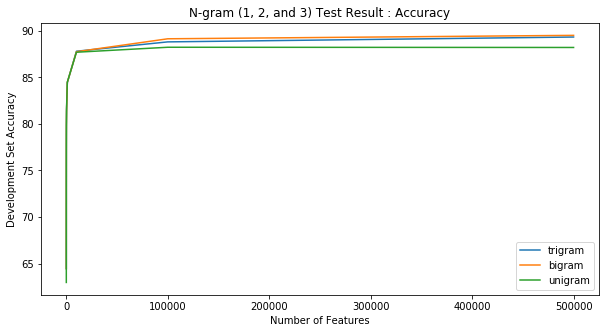

In [22]:
# Set up plot
plt.figure(figsize=(10,5))
plt.title("N-gram (1, 2, and 3) Test Result : Accuracy")
plt.xlabel("Number of Features")
plt.ylabel("Development Set Accuracy")

# Plot model for each n-gram
plt.plot(feature_result_tg['Features'], feature_result_tg['Accuracy'], label='trigram')
plt.plot(feature_result_bg['Features'], feature_result_bg['Accuracy'], label='bigram')
plt.plot(feature_result_ug['Features'], feature_result_ug['Accuracy'], label='unigram')
plt.legend()

The bigram model shows the best accuracy. The trigram model has a similar curve with slightly less accuracy. The unigram model clearly performs the worst of the three.

### Models 7-9: TFIDFVectorizer Logistic Regression

#### Model 7: Unigram TFIDF

In [23]:
feature_result_ugt = nfeature_accuracy_checker(vectorizer=TfidfVectorizer(),
                                              ngram_range=(1, 1))
feature_result_ugt

,Features,Accuracy,Improvement,Train-test time
0,5,64.912853,14.880214,8.207914
1,25,73.523076,23.490437,9.083412
2,50,77.661727,27.629088,8.589872
3,75,78.755141,28.722501,8.651405
4,100,79.685358,29.652719,8.819736
5,250,81.320582,31.287943,9.146962
6,1000,84.026372,33.993733,9.258134
7,10000,87.110777,37.078138,9.671869
8,100000,87.597102,37.564462,10.385885
9,500000,87.890854,37.858215,11.839043


#### Model 8: Bigram TFIDF

In [24]:
feature_result_bgt = nfeature_accuracy_checker(vectorizer=TfidfVectorizer(),
                                              ngram_range=(1, 2))
feature_result_bgt

,Features,Accuracy,Improvement,Train-test time
0,5,64.903062,14.870422,23.678628
1,25,73.434950,23.402311,23.645199
2,50,77.381030,27.348391,23.667772
3,75,78.826947,28.794308,24.383527
4,100,79.721261,29.688622,24.656708
5,250,81.176970,31.144331,24.059945
6,1000,84.107970,34.075331,24.612776
7,10000,87.345780,37.313141,25.430136
8,100000,88.011620,37.978980,26.928151
9,500000,87.825576,37.792937,32.730873


#### Model 9: Trigram TFIDF

In [25]:
feature_result_tgt = nfeature_accuracy_checker(vectorizer=TfidfVectorizer(),
                                              ngram_range=(1, 3))
feature_result_tgt

,Features,Accuracy,Improvement,Train-test time
0,5,64.903062,14.870422,50.665561
1,25,73.434950,23.402311,50.219181
2,50,77.381030,27.348391,45.924001
3,75,78.826947,28.794308,46.353032
4,100,79.721261,29.688622,46.168941
5,250,81.173706,31.141067,46.457861
6,1000,84.062276,34.029636,46.882427
7,10000,87.264182,37.231543,48.006894
8,100000,87.877799,37.845160,49.401294
9,500000,87.776617,37.743978,54.951850


#### Comparison of Different n-Grams and Vectorizers

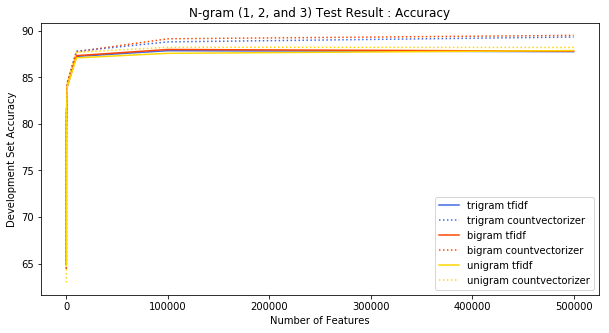

In [26]:
# Setup plot
plt.figure(figsize=(10,5))
plt.title("N-gram (1, 2, and 3) Test Result : Accuracy")
plt.xlabel("Number of Features")
plt.ylabel("Development Set Accuracy")

# Plot model for each ngram
plt.plot(feature_result_tgt['Features'], feature_result_tgt['Accuracy'],
         label='trigram tfidf', color='royalblue')
plt.plot(feature_result_tg['Features'], feature_result_tg['Accuracy'],
         label='trigram countvectorizer', color='royalblue', linestyle=':')

plt.plot(feature_result_bgt['Features'], feature_result_bgt['Accuracy'],
         label='bigram tfidf', color='orangered')
plt.plot(feature_result_bg['Features'], feature_result_bg['Accuracy'],
         label='bigram countvectorizer', color='orangered', linestyle=':')

plt.plot(feature_result_ugt['Features'], feature_result_ugt['Accuracy'],
         label='unigram tfidf', color='gold')
plt.plot(feature_result_ug['Features'], feature_result_ug['Accuracy'],
         label='unigram countvectorizer', color='gold', linestyle=':')
plt.legend()

Unlike with CountVectorizer, the TFIDF unigram model performs best. However, all of the CountVectorizer models are more accurate than the TFIDF models, particularly as the number of features increases.

### Model 10: Ensemble

Estimate results for each classifier:

In [80]:
# Define classifiers implemented by ensemble
from time import time

classifiers = {"Logistic Regression": LogisticRegression(solver='saga'),
               "LinearSVC": LinearSVC(),
               "Multinomial NB": MultinomialNB(),
               "Bernoulli NB": BernoulliNB(),
               "Ridge Classifier": RidgeClassifier(),
               "AdaBoost": AdaBoostClassifier(),
               "Perceptron": Perceptron(),
               "Passive-Aggresive": PassiveAggressiveClassifier(),
               "Nearest Centroid": NearestCentroid()}

# Define vectorizer used in pipeline
vectorizer = CountVectorizer(stop_words=None, max_features=100000, ngram_range=(1, 2))

# Estimate accuracy, improvement and time for each classifier
result = []
for clf_name in classifiers.keys():
    checker_pipeline = Pipeline([('vectorizer', vectorizer),
                                 ('classifier', classifiers[clf_name])])
    clf_accuracy, tt_time, null_accuracy = accuracy_summary(checker_pipeline, x_train,
                                                            y_train, x_dev, y_dev)
    improvement = (clf_accuracy - null_accuracy) * 100
    result.append((clf_name, clf_accuracy * 100, improvement, tt_time))

# Transform result list to dataframe
columns = ['Classifier', 'Accuracy', 'Improvement', 'Train-Test Time']
clfs_results = pd.DataFrame(data=result, columns=columns)
clfs_results

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in PassiveAgg

,Classifier,Accuracy,Improvement,Train-test time
0,Logistic Regression,89.216006,39.183367,60.086118
1,LinearSVC,86.621189,36.588550,63.832501
2,Multinomial NB,85.057771,35.025132,24.542395
3,Bernoulli NB,86.209935,36.177296,24.932477
4,Ridge Classifier,86.862719,36.830080,74.184992
5,AdaBoost,82.828514,32.795874,74.189734
6,Perceptron,81.346694,31.314054,24.658473
7,Passive-Aggresive,86.807233,36.774594,24.318225
8,Nearest Centroid,69.639010,19.606371,24.797372


Build ensemble model using the best 5 classifiers:

In [81]:
# Find 5 best classifiers
clfs_top5 = clfs_results.sort_values(by='Accuracy', ascending=False)['Classifier'][0:5].values.tolist()
print(clfs_top5)

['Logistic Regression', 'Ridge Classifier', 'Passive-Aggresive', 'LinearSVC', 'Bernoulli NB']


In [98]:
# Estimate ensemble
estimators = [(clfs_top5[0], classifiers[clfs_top5[0]]),
              (clfs_top5[1], classifiers[clfs_top5[1]]),
              (clfs_top5[2], classifiers[clfs_top5[2]]),
              (clfs_top5[3], classifiers[clfs_top5[3]]),
              (clfs_top5[4], classifiers[clfs_top5[4]])]
ensemble_clf = VotingClassifier(estimators = estimators, voting='hard')
checker_pipeline = Pipeline([('vectorizer', CountVectorizer(ngram_range=(1, 2))),
                             ('classifier', ensemble_clf)
                            ])

# Get accuracy and other results
clf_accuracy, tt_time, null_accuracy = accuracy_summary(checker_pipeline, x_train, y_train, x_dev, y_dev)

print(f"""
Ensemble model
Accuracy: {clf_accuracy * 100:.2f}
Improvement: {(clf_accuracy - null_accuracy) * 100:.2f}%
Train-test time: {tt_time}
""")

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in PassiveAggressiveClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)



Ensemble model
Accuracy: 89.89
Improvement: 39.86%
Train-test time: 267.02664399147034



The ensemble model has slightly better accuracy than our previous best model, the bigram CountVectorizer logistic regression model (Model 5).

### Models 11-14: Doc2Vec

In [87]:
# Define labelize function
def labelize_tweets_ug(tweets, label):
    """Takes a list of tweets and transform then into unique labels.
    
    Args:
        tweets (array): tweets to be labelized.
        
        label (array): label to be added to labelized tweets.
        
    Returns:
        (array) labelized tweets.
    
    """
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(LabeledSentence(t.split(), [prefix + '_%s' % i]))
    return result

# Create word2vec array
all_x = pd.concat([x_train,x_dev,x_test])
all_x_w2v = labelize_tweets_ug(all_x, 'all')

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).


#### Model 11: DBOW (Distributed Bag Of Words)

In [88]:
# Build doc2vec model
cores = multiprocessing.cpu_count()
model_ug_dbow = Doc2Vec(dm=0, vector_size=100, negative=5, min_count=2, 
                        workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_dbow.build_vocab([x for x in tqdm(all_x_w2v)])

# Train model on vocabulary
for epoch in range(10):
    model_ug_dbow.train(utils.shuffle([x for x in tqdm(all_x_w2v)]), 
                        total_examples=len(all_x_w2v), epochs=10)
    model_ug_dbow.alpha -= 0.002
    model_ug_dbow.min_alpha = model_ug_dbow.alpha

def get_vectors(model, corpus, size):
    """ Vectories the corpus up to the size defined.
    
    Args:
        model: trained doc2vec model.
        
        corpus (array): corpus of text that will be transformed.
        
        size (int): size of resulting vector
        
    Returns:
        (array): vector of transformed corpus.
    
    """
    vecs = np.zeros((len(corpus), size))
    n = 0
    for i in corpus.index:
        prefix = 'all_' + str(i)
        vecs[n] = model.docvecs[prefix]
        n += 1
    return vecs

# Get vectors from training and development data
train_vecs_dbow = get_vectors(model_ug_dbow, x_train, 100)
dev_vecs_dbow = get_vectors(model_ug_dbow, x_dev, 100)

# Train logistic regression model and get accuracy on development data
clf = LogisticRegression()
clf.fit(train_vecs_dbow, y_train)
clf.score(dev_vecs_dbow, y_dev)

100%|██████████| 306376/306376 [00:00<00:00, 1987466.28it/s]
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8315164175207259

The DBOW model is not as accurate as the previous logistic regression models, nor the ensemble model (Model 10)

#### Model 12: DMC (Distributed Memory Concatenation)

In [89]:
# Build doc2vec model
cores = multiprocessing.cpu_count()
model_ug_dmc = Doc2Vec(dm=1, dm_concat=1, vector_size=100, window=2, 
                       negative=5, min_count=2, workers=cores, 
                       alpha=0.065, min_alpha=0.065)
model_ug_dmc.build_vocab([x for x in tqdm(all_x_w2v)])

# Train model on vocabulary
for epoch in range(10):
    model_ug_dmc.train(utils.shuffle([x for x in tqdm(all_x_w2v)]), 
                       total_examples=len(all_x_w2v), epochs=10)
    model_ug_dmc.alpha -= 0.002
    model_ug_dmc.min_alpha = model_ug_dmc.alpha

# Get vectors from training and development data
train_vecs_dmc = get_vectors(model_ug_dmc, x_train, 100)
dev_vecs_dmc = get_vectors(model_ug_dmc, x_dev, 100)

# Train logistic regression model and get accuracy on development data
clf = LogisticRegression()
clf.fit(train_vecs_dmc, y_train)
clf.score(dev_vecs_dmc, y_dev)

100%|██████████| 306376/306376 [00:00<00:00, 2017207.95it/s]
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5694235916182518

At less than 57% accuracy, the DMC model performance is unimpressive. However, the model does seems to have learned the valid vector representation at the word level fairly well. Some examples:

In [90]:
model_ug_dmc.wv.most_similar('president')

[('president…', 0.6766294240951538),
 ('president:', 0.6245754957199097),
 ('president.”', 0.5350331664085388),
 ('president,', 0.524033784866333),
 ('People’', 0.5017796754837036),
 ('president.', 0.5017657279968262),
 ('@USNavy', 0.5016481280326843),
 ('pun', 0.4916541278362274),
 ('official,', 0.49117565155029297),
 ('musician', 0.49103689193725586)]

In [91]:
model_ug_dmc.wv.most_similar('shooting')

[('shootings:', 0.6872410774230957),
 ('stabbing', 0.6703215837478638),
 ('shootings', 0.6487616896629333),
 ('shootings,', 0.6412950158119202),
 ('shooting.', 0.6278271675109863),
 ('@juliareinstein:', 0.6235000491142273),
 ('car-crash', 0.619346022605896),
 ('shootin…', 0.6149117946624756),
 ('shooting:', 0.6003924608230591),
 ('stabbings', 0.5955531597137451)]

#### Model 13: DMM (Distributed Memory Mean)

In [92]:
# Build doc2vec model
cores = multiprocessing.cpu_count()
model_ug_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=100, window=4, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_dmm.build_vocab([x for x in tqdm(all_x_w2v)])

# Train model on vocabulary
for epoch in range(10):
    model_ug_dmm.train(utils.shuffle([x for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=10)
    model_ug_dmm.alpha -= 0.002
    model_ug_dmm.min_alpha = model_ug_dmm.alpha

# Get vectors from training and development data
train_vecs_dmm = get_vectors(model_ug_dmm, x_train, 100)
dev_vecs_dmm = get_vectors(model_ug_dmm, x_dev, 100)

# Train logistic regression model and get accuracy on development data
clf = LogisticRegression()
clf.fit(train_vecs_dmm, y_train)
clf.score(dev_vecs_dmm, y_dev)

100%|██████████| 306376/306376 [00:00<00:00, 2105850.31it/s]
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7716234741171095

The DMM model far outperforms the DMC model. This is supported by examination of its learning at the word level, which also appears to be improved:

In [93]:
model_ug_dmm.wv.most_similar('president')

[('president,', 0.5855997800827026),
 ('mother', 0.5672438740730286),
 ('boss', 0.5598231554031372),
 ('president…', 0.5532160997390747),
 ('leader', 0.5377174019813538),
 ('ambassador', 0.5336760878562927),
 ('President…', 0.522308886051178),
 ('president.', 0.5210877656936646),
 ('citizens', 0.5126439332962036),
 ('neighbor', 0.5091742277145386)]

In [94]:
model_ug_dmc.wv.most_similar('shooting')

[('shootings:', 0.6872410774230957),
 ('stabbing', 0.6703215837478638),
 ('shootings', 0.6487616896629333),
 ('shootings,', 0.6412950158119202),
 ('shooting.', 0.6278271675109863),
 ('@juliareinstein:', 0.6235000491142273),
 ('car-crash', 0.619346022605896),
 ('shootin…', 0.6149117946624756),
 ('shooting:', 0.6003924608230591),
 ('stabbings', 0.5955531597137451)]

#### Model 14: Combined DBOW+DMM Model

In [97]:
def get_concat_vectors(model1, model2, corpus, size):
    """Takes two models and return doc2vec concatenated vectors.
    
    Args:
        model1: first model to transform and concatenate.
        
        model2: second model to transform and concatenate.
        
        corpus (array): corpus of text that will be transformed.
        
        size (int): size of resulting vectors
    
    Returns:
        (array): two vectors concatenated.
    """
    vecs = np.zeros((len(corpus), size))
    n = 0
    for i in corpus.index:
        prefix = 'all_' + str(i)
        vecs[n] = np.append(model1.docvecs[prefix],model2.docvecs[prefix])
        n += 1
    return vecs

In [96]:
# Get vectors from training and development data
train_vecs_dbow_dmm = get_concat_vectors(model_ug_dbow,model_ug_dmm, x_train, 200)
dev_vecs_dbow_dmm = get_concat_vectors(model_ug_dbow,model_ug_dmm, x_dev, 200)

# Train logistic regression model and get accuracy on development data
clf = LogisticRegression()
clf.fit(train_vecs_dbow_dmm, y_train)
clf.score(dev_vecs_dbow_dmm, y_dev)

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8399699719302827

Of the Doc2Vec models, the DBOW+DMM model is the most accurate. However, the CountVectorizer logistic regression models all perform better. 

## Model 5 Development

Given the high accuracy and parsimony of our intitial CountVectorizer bigram logistic regression model (Model 5), we selected this model for further development.

### Stop Word Removal

In [30]:
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

,real,troll,total
https,195129,200634,395763
co,193992,201048,395040
to,57108,36722,93830
the,75335,15924,91259
in,41252,46682,87934
of,40905,23588,64493
for,24091,21394,45485
on,24203,15026,39229
trump,30352,8168,38520
and,25274,8751,34025


In [31]:
my_stop_words = frozenset(list(term_freq_df.sort_values(by='total', 
                                                        ascending=False).iloc[:10].index))

In [32]:
lr2 = LogisticRegression(penalty='l2', tol=0.01, solver='saga',
                            multi_class='multinomial', class_weight='balanced', 
                            random_state=2019)

In [33]:
print("BIGRAM WITH ALL STOP WORDS\n")
feature_result_bg2 = nfeature_accuracy_checker(ngram_range=(1, 2), 
                                               n_features = (5, 500000),
                                               classifier = lr2)
feature_result_bg2

BIGRAM WITH ALL STOP WORDS



,Features,Accuracy,Improvement,Train-test time
0,5,64.452641,14.420001,30.086056
1,500000,89.519551,39.486912,39.222971


In [34]:
print("BIGRAM WITHOUT STANDARD STOP WORDS\n")
feature_result_wosw = nfeature_accuracy_checker(vectorizer = CountVectorizer(stop_words='english'), 
                                                ngram_range=(1, 2), 
                                                n_features = (5, 500000),
                                                classifier = lr2)
feature_result_wosw

BIGRAM WITHOUT STANDARD STOP WORDS



,Features,Accuracy,Improvement,Train-test time
0,5,53.942816,3.910177,25.195057
1,500000,88.364123,38.331484,34.683518


In [35]:
print("BIGRAM WITHOUT CORPUS-SPECIFIC STOP WORDS (Top 10)\n")
feature_result_wocsw = nfeature_accuracy_checker(vectorizer = CountVectorizer(stop_words=my_stop_words), 
                                                 ngram_range=(1, 2), 
                                                 n_features = (5, 500000),
                                                 classifier = lr2)
feature_result_wocsw

BIGRAM WITHOUT CORPUS-SPECIFIC STOP WORDS (Top 10)



,Features,Accuracy,Improvement,Train-test time
0,5,55.744500,5.711861,22.820865
1,500000,88.037731,38.005092,34.304343


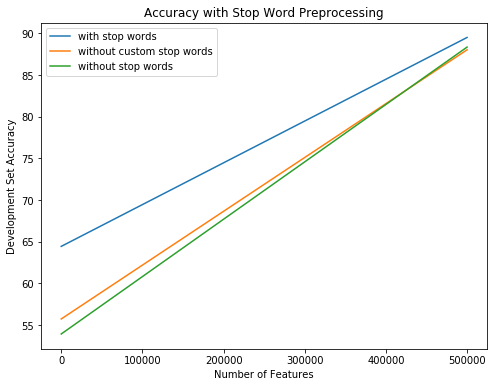

In [36]:
plt.figure(figsize=(8,6))

plt.plot(feature_result_bg2.Features, 
         feature_result_bg2.Accuracy, 
         label='with stop words')
plt.plot(feature_result_wocsw.Features, 
         feature_result_wocsw.Accuracy,
         label='without custom stop words')
plt.plot(feature_result_wosw.Features, 
         feature_result_wosw.Accuracy,
         label='without stop words')

plt.title("Accuracy with Stop Word Preprocessing")
plt.xlabel("Number of Features")
plt.ylabel("Development Set Accuracy")
plt.legend()

Accuracy is clearly best with the stop words preserved in the data, although it appears that it will converge at very high numbers of features.

### Custom Preprocessing Based on Confused Tweets

In [37]:
# bi-gram vectorizer
bigram_vectorizer = CountVectorizer(ngram_range=(1, 2),
                                     token_pattern=r'\b\w+\b', min_df=1)
W_2 = bigram_vectorizer.fit_transform(x_train)
dev_dtm_2 = bigram_vectorizer.transform(x_dev)

# Instantiate logistic regresion object
tweets = LogisticRegression(penalty='l2', solver='saga',
                            multi_class='multinomial', class_weight='balanced',
                            random_state=seed)
tweets.fit(W_2, y_train)
predicted_labels = tweets.predict(dev_dtm_2)

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


#### Confusion Matrix

In [38]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

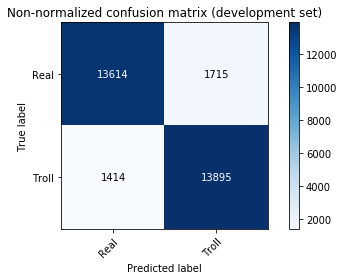

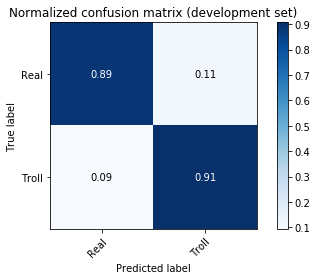

In [41]:
# Non-normalized confusion matrix
plot_confusion_matrix(y_dev, predicted_labels, classes=['Real', 'Troll'], normalize=False,
                      title='Non-normalized confusion matrix (development set)')

# Normalized confusion matrix
plot_confusion_matrix(y_dev, predicted_labels, classes=['Real', 'Troll'], normalize=True,
                      title='Normalized confusion matrix (development set)')

#### The Most Confused Tweets

In [42]:
def max_idx(a,n):
    """ 
    returns a list with the indexes for the n max values in a
    Args:
    ----
    a: list
    n: int
    Returns: list
    """
    return np.argsort(a)[::-1][:n]

In [43]:
def most_confused_tweets(n_examples):
    """ 
    Prints the top n_examples most confused tweets.
    Most confused is defined as where the ratio R is largest, where R is:
    maximum predicted probability / predicted probability of the true label
    Args:
    ----
    n_examples: int
    Returns: in place
    """
    
    d = {0 :'real', 1 : 'troll'}
    
    # estimate probabilities for dev data and R ratios
    predicted_labels = tweets.predict(dev_dtm_2)
    probabilities = tweets.predict_proba(dev_dtm_2)
        
    # compute R
    R = [np.max(probabilities[idx,]) / probabilities[idx, label]\
                 for idx, label in zip(range(y_dev.shape[0]), y_dev)]
    
    # find the top n_examples where R is largest
    examples = max_idx(R, n_examples)
    
    # print the examples
    for example in examples:
        true_label = y_dev.values[example]
        print(
            f"Example {example}\n"
            f"True Label: {d[true_label]}\n"
            f"Predicted Label: {d[predicted_labels[example]]}\n" 
            f"R ratio: {R[example]:.2f}\n"
            f"Predicted Probability: {np.max(probabilities[example,])}\n"
            f"Estimated Probability of True label: {probabilities[example, true_label]}\n"
            f"{x_dev.values[example]}\n")

most_confused_tweets(20)

Example 8126
True Label: troll
Predicted Label: real
R ratio: 691563.09
Predicted Probability: 0.9999985540024191
Estimated Probability of True label: 1.4459975809369962e-06
RT @DanScavino: Reporters bragging POTUS called them out of the blue on Fri are forgetting they sent emails requesting he call for their st…

Example 23425
True Label: troll
Predicted Label: real
R ratio: 90401.83
Predicted Probability: 0.9999889383991862
Estimated Probability of True label: 1.106160081375083e-05
Trump: "Our campaign is about representing the great majority of Americans who turn on the TV &amp; don’t hear anyone speaking for them."

Example 21948
True Label: real
Predicted Label: troll
R ratio: 51303.27
Predicted Probability: 0.9999805084441794
Estimated Probability of True label: 1.9491555820717702e-05
5 things for Monday May 1st: 

1. Donald Trump
2. Weather
3. Turkey
4. Politics
5. Milwaukee jail death… https://t.co/RIUfzZ4OvK

Example 17682
True Label: troll
Predicted Label: real
R ratio: 46332

#### Custom Preprocessing

Above, we explored removing the standard English stop words and also the top 10 most frequent words; in both cases, we found that the preprocessing did not improve accuracy. Based on the most confused tweets (above), we tried a more surgical preprocessing strategy. 
Just for reference:  we also explored other pre-processing alternatives such as removing numbers, prefixes, cut long words, the results were not interesting and we are not including them in this notebook.

In [44]:
def empty_preprocessor(s):
    ''' 
    Preprocessor function that does nothing, used for control.
    Args:
    ----
    s: string to be processed
    Returns:
    -------
    s: string 
    '''
    return s

confusing_words = {'via', 'http', 'https'}

def confusing_words_preprocessor(s):
    """
    Removes confusing words from s
    Args:
    ----
    s: string
    Returns:
    -------
    string without the confusing words
    """
    words = s.split(' ')
    words = [word for word in words if word not in confusing_words]
    return " ".join(words) 

def better_preprocessor(t):
    """
    Applies confusing_words_preprocessor to a tweet.  
    Args:
    ----
    t: tweet text
    Returns:
    -------
    tweet text after removing confusing words
    """
    
    words = t.split(' ')
    words = [confusing_words_preprocessor(word) for word in words]
    return " ".join(words)  

In [45]:
def prepro_comp(preprocessors):
    """
    Computes vocabulary based on preprocessors functions and determines accuracy.
    Args:
    ----
    preprocessors: 
    Returns: in place.
    -------
    
    """

    for p in preprocessors:
        # compute the vocabulary and transform text into feature vectors using better_preprocessor
        bigram_vectorizer_better = CountVectorizer(preprocessor=p, ngram_range=(1, 2), 
                                             token_pattern=r'\b\w+\b', min_df=1)
        W_2_better = bigram_vectorizer_better.fit_transform(x_train)
        dev_dtm_better_2 = bigram_vectorizer_better.transform(x_dev)

        print (
            f"Preprocessor: {p} \n"
            f"Size of Vocabulary: {W_2_better.shape[1]}")

        # train a logistic regression model 
        tweets1 = LogisticRegression(penalty='l2', solver='saga',
                                  multi_class='multinomial', class_weight='balanced',
                                     random_state=seed)
        tweets1.fit(W_2_better, y_train)
        dev_dtm_better_2 = bigram_vectorizer_better.transform(x_dev)
        predicted_labels = tweets1.predict(dev_dtm_better_2)
        print(f"Accuracy Score: {accuracy_score(y_dev, predicted_labels)*100:.2f}\n")

preprocessors = [None, empty_preprocessor, better_preprocessor]
prepro_comp(preprocessors)

Preprocessor: None 
Size of Vocabulary: 1850799


/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Accuracy Score: 89.79

Preprocessor: <function empty_preprocessor at 0x1a38e680d0> 
Size of Vocabulary: 1995747
Accuracy Score: 90.22

Preprocessor: <function better_preprocessor at 0x1a38e6d048> 
Size of Vocabulary: 1995082
Accuracy Score: 90.16



Using the custom preprocesser gives us a small bump in accuracy to 90.16% over the default preprocessor. However, interestingly, the empty preprocessor is slightly more accurate at 90.22%.

In [46]:
# Define optimal preprocessor for future use.
opt_prepro = empty_preprocessor

#### Confused Tweet Stop Words

In [47]:
# Instantiate the vectorizer.
vectorizer_P434 = CountVectorizer(preprocessor=opt_prepro, ngram_range=(1, 2), 
                                             token_pattern=r'\b\w+\b')

# Fit and transform the training data into a document-term matrix.
train_dtm = vectorizer_P434.fit_transform(x_train)

# Transform the development data (using fitted vocabulary) into a document-term matrix.
dev_dtm = vectorizer_P434.transform(x_dev)

# Create a Logistic Regression Classifier 
# and train it using the training set.
logreg_P434 = LogisticRegression(penalty='l2', tol=0.01, solver='saga',
                    multi_class='multinomial', class_weight='balanced', 
                    random_state=0).fit(train_dtm, y_train)

# Output predictions.
y_pred_P434 = logreg_P434.predict(dev_dtm)

df_P434 = pd.DataFrame(x_dev)
df_P434["actual"] = y_dev
df_P434["predicted"] = y_pred_P434

incorrect = df_P434[df_P434["actual"] != df_P434["predicted"]]
incorrect.head(20)

,tweet_text,actual,predicted
279869,Judge cancels West explosion trial after serie...,0,1
286695,LeBron James’ teammates defeat LeBron James in...,0,1
268868,Al Gore says 'ethical reasons' could end Trump...,0,1
167203,Undocumented activist fights for her children'...,0,1
117946,TV writers seek N.Y. law to boost diversity in...,1,0
229900,"Senators mock photo of ""Brooklyn barbecue"" htt...",0,1
93219,‘Birth of a Nation’ star Nate Parker opens up ...,1,0
242695,wut https://t.co/m4FWOcWxiw,0,1
62518,Herman Wesley Powery II received his Doctor of...,1,0
284879,Judge rips 'privileged' young adults for doing...,0,1


In [48]:
cvec_434 = CountVectorizer()
cvec_434.fit(incorrect.tweet_text)
len(cvec_434.get_feature_names())

12776

In [49]:
real_doc_matrix_i = cvec_434.transform(incorrect[incorrect.actual == 0].tweet_text)
troll_doc_matrix_i = cvec_434.transform(incorrect[incorrect.actual == 1].tweet_text)

real_tf_i = np.sum(real_doc_matrix_i,axis=0)
troll_tf_i = np.sum(troll_doc_matrix_i,axis=0)

real_i = np.squeeze(np.asarray(real_tf_i))
troll_i = np.squeeze(np.asarray(troll_tf_i))

term_freq_df_i = pd.DataFrame([real_i,troll_i],
                            columns=cvec_434.get_feature_names()).transpose()

In [50]:
term_freq_df_i.columns = ['real', 'troll']
term_freq_df_i['total'] = term_freq_df_i['real'] + term_freq_df_i['troll']

Examine the top 20 features of the most confused tweets:

In [51]:
term_freq_df_i.sort_values(by='total', ascending=False).iloc[:20]

,real,troll,total
co,2572,1957,4529
https,2569,1954,4523
to,440,422,862
in,408,316,724
the,205,435,640
of,273,272,545
for,242,178,420
trump,104,252,356
on,159,149,308
and,113,182,295


Create a list of the top 20 features of the most confused tweets:

In [52]:
my_stop_words_i = frozenset(list(term_freq_df_i.sort_values(by='total', 
                                                        ascending=False).iloc[:20].index))

Run the model with the top 20 features of the most confused tweets removed:

In [53]:
print("BIGRAM WITHOUT CORPUS-SPECIFIC STOP WORDS (Top 20 Incorrect)\n")
feature_result_wocswi = nfeature_accuracy_checker(vectorizer=CountVectorizer(stop_words=my_stop_words_i), 
                                                  ngram_range=(1, 2), 
                                                  n_features = (5, 12000),
                                                  classifier = lr2)
feature_result_wocswi

BIGRAM WITHOUT CORPUS-SPECIFIC STOP WORDS (Top 20 Incorrect)



,Features,Accuracy,Improvement,Train-test time
0,5,57.647366,7.614727,21.722055
1,12000,86.425354,36.392715,25.150536


Accuracy is not improved by removing the incorrect prediction corpus-specific stop words; therefore, it cannot be used for optimization.

### min_df Optimization

In [54]:
'''
Fits a logistic regression model and try a range of values for min_df. 
'''

def logreg_min_df(min_dfs):

    '''
    Args:
        min_dfs (list): list of min_df values to try
        
    Returns:
        float, accuracy score
    '''
     
    for i in min_dfs:
        
        # Instantiate the vectorizer.
        vectorizer = CountVectorizer(preprocessor=opt_prepro, ngram_range=(1, 2), 
                                             token_pattern=r'\b\w+\b', min_df=i)

        # Fit and transform the training data into a document-term matrix.
        train_dtm = vectorizer.fit_transform(x_train)

        # Transform the development data (using fitted vocabulary) into a document-term matrix.
        dev_dtm = vectorizer.transform(x_dev)

        # Create a Logistic Regression Classifier 
        # and train it using the training set.
        logreg_P44 = LogisticRegression(penalty='l2', solver='saga',
                            multi_class='multinomial', class_weight='balanced', 
                            random_state=2019).fit(train_dtm, y_train)

        # Output predictions.
        y_pred_P44 = logreg_P44.predict(dev_dtm)
        print('min_df: %d' %(i))
        print('Accuracy: %3.4f' 
              %(metrics.accuracy_score(y_dev, y_pred_P44)))

min_dfs = range(1, 6)
logreg_min_df(min_dfs)

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


min_df: 1
Accuracy: 0.9022
min_df: 2
Accuracy: 0.8981
min_df: 3
Accuracy: 0.8959
min_df: 4
Accuracy: 0.8959
min_df: 5
Accuracy: 0.8942


Accuracy appears to decline as the min_df value increases; therefore, it cannot be used for optimization.

### max_features Optimization

In [55]:
'''
Fits a logistic regression model and find the optimal value for max_features. 
'''

def logreg_max_feats(max_feats):

    '''
    Args:
        max_feats (list): list of max_features values to try
        
    Returns:
        float, accuracy score
    '''
     
    for i in max_feats:
        
        # Instantiate the vectorizer.
        vectorizer = CountVectorizer(preprocessor=opt_prepro, ngram_range=(1, 2), 
                                             token_pattern=r'\b\w+\b', max_features=i)

        # Fit and transform the training data into a document-term matrix.
        train_dtm = vectorizer.fit_transform(x_train)

        # Transform the development data (using fitted vocabulary) into a document-term matrix.
        dev_dtm = vectorizer.transform(x_dev)

        # Create a Logistic Regression Classifier 
        # and train it using the training set.
        logreg_P45 = LogisticRegression(penalty='l2', solver='saga',
                            multi_class='multinomial', class_weight='balanced', 
                            random_state=seed).fit(train_dtm, y_train)

        # Output predictions.
        y_pred_P45 = logreg_P45.predict(dev_dtm)
        print('max_features: %d' %(i))
        print('Accuracy: %3.4f' 
              %(metrics.accuracy_score(y_dev, y_pred_P45)))

max_feats = (50000, 250000, 500000, 750000, 1000000)
logreg_max_feats(max_feats)

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_features: 50000
Accuracy: 0.8884
max_features: 250000
Accuracy: 0.8969
max_features: 500000
Accuracy: 0.8987
max_features: 750000
Accuracy: 0.8998
max_features: 1000000
Accuracy: 0.9009


Accuracy appears to increase as the max_features value increases; therefore, it cannot be used for optimization.

### C Value Optimization

We performed a grid search to determine the C value that optimizes accuracy.  In addition we also did not want to affect regularization so we added the constraint $0< C <= 1$. Please refer to  [GridSearch Notebook](W207FinalProject_GridSearch.ipynb).  The optimal  value is the default value $C=1$.

In [56]:
opt_C = 1

## Understanding the Model

In [57]:
# bi-gram vectorizer
bigram_vectorizer = CountVectorizer(preprocessor=opt_prepro, ngram_range=(1, 2),
                                     token_pattern=r'\b\w+\b', min_df=1)
W_2 = bigram_vectorizer.fit_transform(x_train)
dev_dtm_2 = bigram_vectorizer.transform(x_dev)

# Instantiate logistic regresion object with best C value
tweets = LogisticRegression(penalty='l2', C=opt_C, solver='saga',
                                  multi_class='multinomial', class_weight='balanced', random_state=seed)
tweets.fit(W_2, y_train)

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l2',
          random_state=2019, solver='saga', tol=0.0001, verbose=0,
          warm_start=False)

### The Largest-Weight Features for Troll Prediction

In [58]:
def features_with_max_weights(lr_object, bow, n):
    """
    Given a logistic regression model and the vocabulary/featues, finds the top n
    features with largest weights
    Args:
    ----
    lr_object: LogisticRegression object
    bow: fitted vectorizer
    n: int
    Returns:
    -------
    results: dataframe with features and associated weights
    """
    
    # find n largest weights for troll
    max_weights_idx = np.argpartition(lr_object.coef_, -n, axis = 1)[:,-n:]
    max_weights_idx = max_weights_idx.flatten()

    # find the associated features
    features_names = bow.get_feature_names()
    max_features = [features_names[w] for w in max_weights_idx]

    # display results
    data = {}
    data = {features_names[idx] : lr_object.coef_[0,idx] for idx in max_weights_idx}
    results = pd.DataFrame.from_dict(data=data, orient='index')
    results.index.name = 'token'
    results.columns = ['weight']
    results.sort_values(by=['weight'], inplace=True, ascending=False)
    return results

In [59]:
# which are the features with largest weight that predict a troll with bigram vocabulary?
features_with_max_weights(tweets, bigram_vectorizer, 50)

,weight
token,
politics,3.977685
ObservationsAtTheMarathon,3.745633
StLouis,3.534137
showbiz,3.385541
sports,3.363161
SanJose,3.166189
news,3.143975
health,2.861870
entertainment,2.821529


### The "Trolliest" Tweets

In [60]:
def trolliest_tweets(lr_object, n_examples):
    """
    Given a logistic regression model, finds the top n_examples with
    higher posterior probability of being predicted as trolls.
    Args:
    ----
    lr_object: Logistic Regression object
    n_examples: int
    Returns:
    -------
    texts: list with 'trolliest' tweets texts
    """
    
    # estimate probabilities for dev data 
    predicted_labels = lr_object.predict(dev_dtm_2)
    probabilities = lr_object.predict_proba(dev_dtm_2)

    max_prob = np.max(probabilities, axis=1)
    sorted_max_prob = np.argsort(max_prob)[::-1]
    
    texts = []
    examples = 0
    
    for idx in sorted_max_prob:
        if predicted_labels[idx] == 1:
            texts.append(x_dev.values[idx])
            examples += 1
            if examples == n_examples:
                break
    return texts
    
trolliest_tweets(tweets, 20)

['Local sports digest: San Jose State third, Cal fourth after first round of Bay Area Intercollegiate  #sports',
 'Kyrie Irving continues to progress for Cleveland Cavs: Cleveland Cavaliers point guard Kyri... https://t.co/i7pWHybj11 #Cleveland #sports',
 'Bay Area sports fans sought for Super Bowl 50 Halftime Show  #news',
 "Shumpert is Cleveland Cavs' 'glue guy': Shooting guard\xa0Iman Shumpert is the Cleveland Caval... https://t.co/qCZz8aGcie #Cleveland #sports",
 "Local sports digest: Santa Clara women's basketball coach Payne departs  #sports",
 'Biggest Winner for February 10, 2016: The "Biggest Winner" in local sports for Wednesday Fe... https://t.co/Xx6G71UAcd #Cleveland #sports',
 'Missouri business groups divided on LGBT-discrimination ban  #business #news',
 '#Idlib | Renewed clashes between Suqour al-Sham Brigade (Ahrar al-Sham) and Jabhat Fatah al-Sham near Ehsim town https://t.co/hX6OiW8aIk',
 'San Jose Sharks beat Edmonton Oilers 2-1 in shootout, Todd McLellan returns to

### The "Realest" Tweets

In [61]:
def realest_tweets(lr_object, n_examples):
    """
    Given a logistic regression model, finds the top n_examples with
    higher posterior probability of being predicted as real news.
    Args:
    ----
    lr_object: Logistic Regression object
    n_examples: int
    Returns:
    -------
    texts: list with 'trolliest' tweets texts
    """

    # estimate probabilities for dev data 
    predicted_labels = lr_object.predict(dev_dtm_2)
    probabilities = lr_object.predict_proba(dev_dtm_2)

    max_prob = np.max(probabilities, axis=1)
    sorted_max_prob = np.argsort(max_prob)[::-1]
    
    texts = []
    examples = 0
    
    for idx in sorted_max_prob:
        if predicted_labels[idx] == 0:
            texts.append(x_dev.values[idx])
            examples += 1
            if examples == n_examples:
                break
    return texts
    
realest_tweets(tweets, 20)

['RT @MSNBC: NEW: @kwelkernbc reports that the White House says the decision on whether to release the Nunes memo will not be rushed and Pres…',
 'RT @ABC: JUST IN: Pres. Trump announces tariffs on $50 billion of Chinese technological goods.\n\n"The United States will implement a 25 perc…',
 'RT @NBCPolitics: JUST IN: The White House pre-advance team for North Korea summit will travel to Singapore as scheduled "in order to prepar…',
 'RT @NBCNews: BREAKING: Conservative Republican Roy Moore defeats Senator Luther Strange, who had been endorsed by President Trump, in Alaba…',
 "RT @hardball: BREAKING: Robert Mueller's prosecutors told Paul Manafort they plan to indict him. (per @nytimes) WATCH:  https://t.co/AClfEe…",
 'RT @FoxBusiness: .@JamieColbyTV joined @TeamCavuto with a preview of the ALL NEW season of #StrangeInheritance. Tune in tonight at 9pm ET o…',
 "RT @ABC: MORE: EPA's internal watchdog to expand review of Scott Pruitt's conduct to include his arrangement to live in a Capi

## Implementation

### Final Model

Finally, we will evaluate model performance with test data.

In [62]:
# transform test data and predicgt 
test_dtm_2 = bigram_vectorizer.transform(x_test)
predicted_labels = tweets.predict(test_dtm_2)
print(f"Accuracy with test data: {accuracy_score(y_test, predicted_labels)}")

Accuracy with test data: 0.9051504667406489


Accuracy with test data is almost 0.3 percent points above accuracy with dev data.

### Calibration

We care about the confidence of the model in its predictions and how the errors are distributed, which is crucial so that  decisions can be made with a good assessment of risks. We proceed to calibrate the model with our best parameters, using dev data.

#### Plot Calibration with $C=1$

p(pred) <= 0.5000000000000    total =   0    accuracy = 0.000
p(pred) <= 0.6000000000000    total = 1344    accuracy = 0.554
p(pred) <= 0.7000000000000    total = 1458    accuracy = 0.610
p(pred) <= 0.8000000000000    total = 1830    accuracy = 0.730
p(pred) <= 0.9000000000000    total = 2968    accuracy = 0.815
p(pred) <= 0.9100000000000    total = 403    accuracy = 0.834
p(pred) <= 0.9200000000000    total = 482    accuracy = 0.898
p(pred) <= 0.9300000000000    total = 533    accuracy = 0.891
p(pred) <= 0.9400000000000    total = 682    accuracy = 0.919
p(pred) <= 0.9500000000000    total = 738    accuracy = 0.909
p(pred) <= 0.9600000000000    total = 847    accuracy = 0.900
p(pred) <= 0.9700000000000    total = 1109    accuracy = 0.930
p(pred) <= 0.9800000000000    total = 1580    accuracy = 0.956
p(pred) <= 0.9900000000000    total = 2669    accuracy = 0.953
p(pred) <= 0.9990000000000    total = 6968    accuracy = 0.986
p(pred) <= 0.9999000000000    total = 4137    accuracy = 0.995

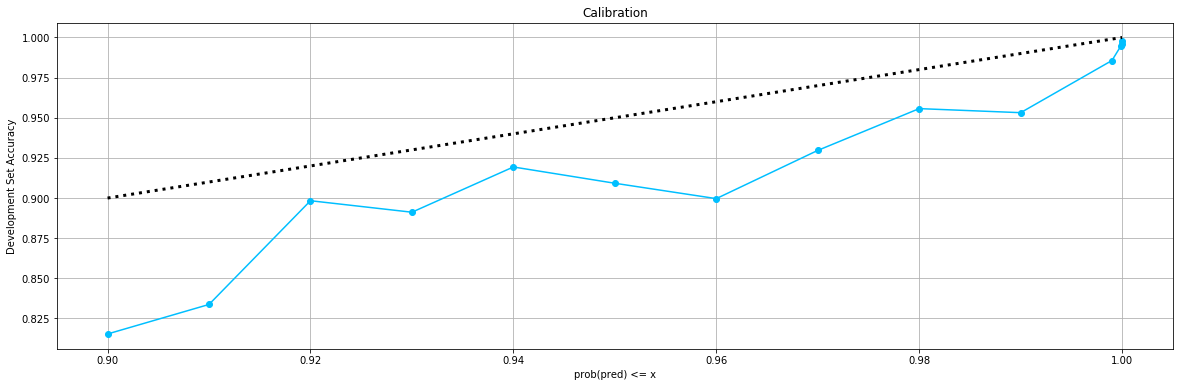

In [66]:
# list of bucket to keep to distribute the examples according to posterior probability
buckets = [0.5, 0.6, 0.7, 0.8, 0.90, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
           0.99, 0.999, 0.9999, 0.99999, 1.0]


def find_bucket(post):
    """
    Given a posterior probability returns the bucket.
    Args:
    ----
    post: int 
    Returns:
    -------
    idx: index in bucket
    """
    for idx,b in enumerate(buckets):
        if post <= b:
            return idx

def calibration(lr_object, X, Y):
    """
    Given a Logistic Regression model, examples and labels plots calibration
    Args:
    ----
    lr_object: Logistic Regression Model
    X: array type
    Y: array type
    Returns: in place
    -------
    """
        
    # initialize the buckets
    correct = [0 for i in buckets]
    total = [0 for i in buckets]

    # get predicted labels and posterior probabilities 
    predicted_labels = lr_object.predict(X)
    post = lr_object.predict_proba(X)

    # find max posterior probability for each sample in dev data
    max_prob=np.max(post,axis=1)

    for post, pred, label in zip(max_prob, predicted_labels, Y):
        idx = find_bucket(post)
        if pred == label:
            correct[idx] += 1
        total[idx] += 1
    
    for i in range(len(buckets)):
        acc = 0.0
        if (total[i] > 0): 
            acc = correct[i] / total[i]
        print( 'p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], acc))
    
    print(f"Accuracy: {accuracy_score(y_dev, predicted_labels)}")

    # plot accuracies vs buckets
    accuracies = []
    for i in range(4, len(buckets)):
        accuracies.append(correct[i] / total[i])
    
    plt.figure(figsize=(20,6))

    plt.plot(buckets[4:], accuracies, marker = "o", color="deepskyblue")
    plt.plot([.9, 1], [.9, 1], "k:", linewidth=3, 
         label="Perfect Calibration")
    plt.title("Calibration")
    plt.xlabel(f"prob(pred) <= x")
    plt.ylabel("Development Set Accuracy")
    plt.grid()
    plt.savefig('calibration.jpg')
    
calibration(tweets, dev_dtm_2, y_dev)

Surprinsingly, the model is over confident.  Generally, Logistic Regression returns well calibrated predictions. We care about the confidence of our model, therefore we will explore calibration with a smaller $C$ value. 

#### Plot Calibration with $C = 0.17$

p(pred) <= 0.5000000000000    total =   0    accuracy = 0.000
p(pred) <= 0.6000000000000    total = 1825    accuracy = 0.565
p(pred) <= 0.7000000000000    total = 2105    accuracy = 0.658
p(pred) <= 0.8000000000000    total = 2682    accuracy = 0.791
p(pred) <= 0.9000000000000    total = 4138    accuracy = 0.874
p(pred) <= 0.9100000000000    total = 611    accuracy = 0.908
p(pred) <= 0.9200000000000    total = 646    accuracy = 0.935
p(pred) <= 0.9300000000000    total = 714    accuracy = 0.951
p(pred) <= 0.9400000000000    total = 846    accuracy = 0.948
p(pred) <= 0.9500000000000    total = 1062    accuracy = 0.948
p(pred) <= 0.9600000000000    total = 1211    accuracy = 0.964
p(pred) <= 0.9700000000000    total = 1411    accuracy = 0.953
p(pred) <= 0.9800000000000    total = 1894    accuracy = 0.978
p(pred) <= 0.9900000000000    total = 2876    accuracy = 0.986
p(pred) <= 0.9990000000000    total = 6001    accuracy = 0.995
p(pred) <= 0.9999000000000    total = 2005    accuracy = 0.9

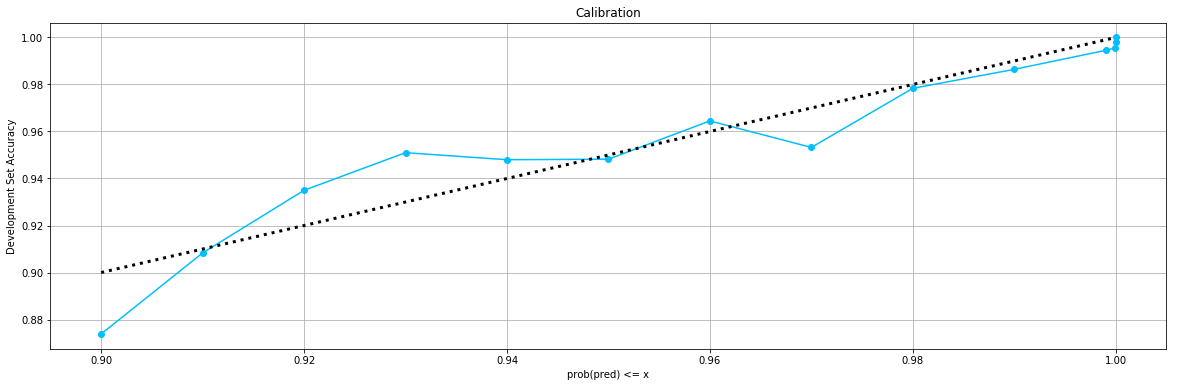

In [67]:
# Instantiate logistic regresion object with best C value
tweets_1 = LogisticRegression(penalty='l2', C=0.17, solver='saga',
                                  multi_class='multinomial', class_weight='balanced', random_state=seed)
tweets_1.fit(W_2, y_train)
calibration(tweets_1, dev_dtm_2, y_dev)

Accuracy decreases by 0.2 percent points (on dev data), but we can observe that the model is more strongly calibrated.

#### Confidence Thresholds


    Examples: 30638
    Predicted Trolls: 15672
    Predicted News: 14966


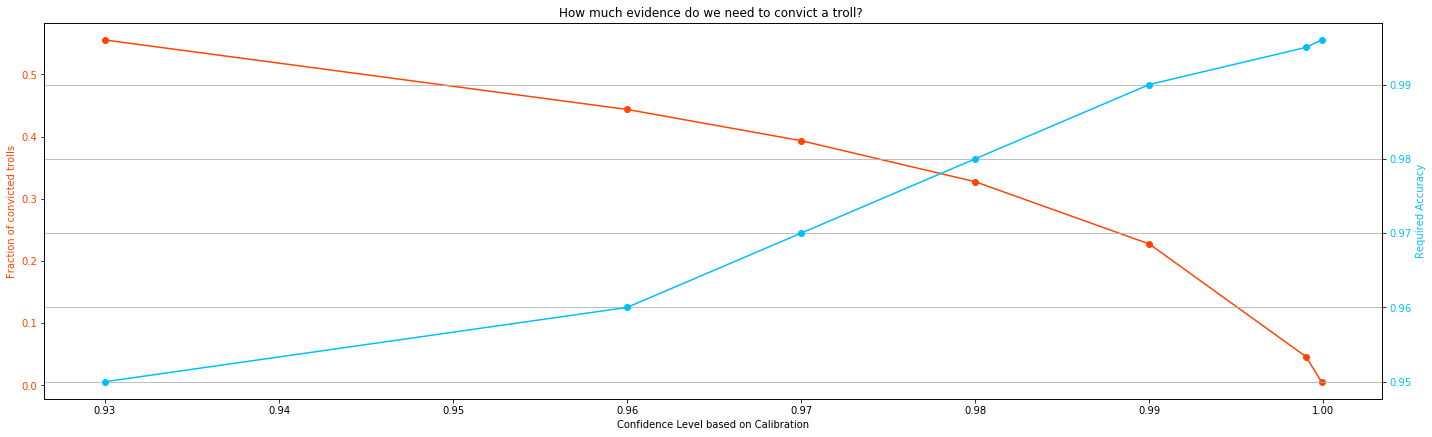

In [65]:
# each tuple is a pair of (accuracy, probability) based on the results of calibration above
thresholds = [(0.95, 0.93), (0.96, 0.96), (0.97, 0.97), (0.98, 0.98), 
              (0.99, 0.99), (0.995, 0.999), (0.996, 0.9999), (1.0, 1.0)]

def find_threshold(post):
    """
    Given a posterior probability returns the pair (accuracy, confidence level).
    Args:
    ----
    post: int 
    Returns:
    -------
    idx: index in thresholds
    """
    for idx, threshold in enumerate(thresholds):
        if post <= threshold[1]:
            return idx

def dont_know(lr_object, X, Y):
    """
    Given a Logistic Regression object, examples and labels plots,
    plots fraction of predicted positive examples that pass the threshold (confidence)
    Args:
    ----
    lr_object: Logistic Regression Model
    X: array type
    Y: array type
    Returns: in place
    -------
    """
    
    # initializations
    troll = 1
    dont_know = [0 for i in thresholds]
    total = len(Y)
    
    # get predicted labels and posterior probabilities 
    predicted_labels = lr_object.predict(X)
    post = lr_object.predict_proba(X)
    
    total_predicted_trolls = np.sum(predicted_labels==1)
    total_predicted_news = total - total_predicted_trolls
    print(f"""
    Examples: {total}
    Predicted Trolls: {total_predicted_trolls}
    Predicted News: {total_predicted_news}""")

    # find max posterior probability for each sample in dev data
    max_prob=np.max(post,axis=1)
    
    for post, pred in zip(max_prob, predicted_labels):
        
        if pred == troll: 
            idx = find_threshold(post)
            dont_know[idx] +=1
    
    convicted_trolls = [0 for i in thresholds]
    for i in range(len(dont_know)):
        convicted_trolls[i] = (total_predicted_trolls-sum(dont_know[:i+1])) / total_predicted_trolls

    # plot fraction of "convicted trolls" vs thresholds
    convicted_trolls = convicted_trolls[:-1]
    confidence_level = [t[1] for t in thresholds[:-1]]
    accuracy = [t[0] for t in thresholds[:-1]]
    fig, ax1 = plt.subplots(figsize=(20,6))

    color = 'orangered'
    ax1.set_xlabel('Confidence Level based on Calibration')
    ax1.set_ylabel("Fraction of convicted trolls", color=color)
    ax1.plot(confidence_level, convicted_trolls, marker = "o", color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  

    color = 'deepskyblue'
    ax2.set_ylabel('Required Accuracy', color=color)  
    ax2.plot(confidence_level, accuracy, marker = "o", color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    fig.tight_layout() 
    plt.title("How much evidence do we need to convict a troll? ")
    plt.grid()
    plt.show()
    fig.savefig('I dont know.jpg')

dont_know(tweets_1, dev_dtm_2, y_dev)

From the plot above, we can see:
* If we require an accuracy of 95%, the confidence level threshold is 93% and we would be able to classify as trolls almost 60% of the predicted trolls.
* If we require an accuracy of 98%, the confidence level threshold is 98% and we would be able to classify as trolls approx. 35% of the predicted trolls.
* If we require an accuracy of 99%, the confidence level threshold is 99% and we would be able to classify as trolls almost 25% of the examples predicted trolls.

## Key Learnings

### Data quality is as important as algorithm quality.

Our models were fed with data coming from varied sources and was obtained using different methods that, in some cases, required multiple steps and writing complex code. Through this process we found how critical it is to get the right data, in the correct type, and to avoid any errors that may reduce the ability of the classifiers to learn and generalize (i.e. both data quality and representativeness).

Through the process of building a fit-for-production model, we have seen the improvements that can be gained through the use of different representations and the different combinations of hyperparameters. However, through multiple iterations, reviews of our code and testing, we found that the quality of the data used to train and test the models is as imortant as the algorithms that use this data.

### Utility is as important as complexity.

We tried some complex algorithms, including ensemble models, random forests, and Doc2Vec. However, in the end, it’s really hard to beat logistic regression! As simple as it is - it just works.

### Process is as important as processing.
We think we could have mitigated some risk in the project with a few predefined checkpoints in the ML pipeline.  Examples: peer code reviews.

## Suggestions for Future Work

### ML Engineering
- Is there additional preprocessing and/or parameter tuning that would increase the model's accuracy?
- Would additional data improve our model? Since we have almost 500,000 features, it would be good to have at least as many examples in our training set.
- Can our algorithm pick out a troll from a random selection of tweets?
- Would our algorithm work for identifying other trolls (e.g. the Venezuelan trolls)?

### Implementation
- How could the algorithm be implemented by Twitter? What other work is required to make the algorithm useful in practice?
- Does the algorithm transcend the specifics of the political context of the training data? How often should it be retrained on new data?
- How could the algorithm be ‘tricked’ or ‘gamed’?

###  Fairness
- Does the engineering/implentation have the potential to falsely identify subsets of legitimate users as trolls?
- How could it be misused?

###  Legality
- What are the legal issues involved with suspending Twitter accounts using machine learning?
- Does curtailing troll activity necessarily infringe on free speech? Would this be a bigger concern if the trolls were American citizens?

###   Research
- What was the practical impact of these trolls' tweets? Did they actually influence people to change their votes in 2016?
- Who was directing the IRA? How was it funded?